En esta versión se considera una covarianza (del ruido) por cada componente. Además, se calcula la verosimilitud directamente, sin recurrir a Scipy, porque **en caso contrario se producen errores numéricos** debidos a la aparición de matrices singulares.

Incluso así, con el conjunto de datos de las caras de Olivetti las matrices singulares son un problema en cuanto el número de componentes es superior a 20 y el número de factores latentes supera 4. Para tratar de aliviar el problema, además de asegurar que las covarianzas son siempre definidas positivas, también se garantiza que la responsabilidad de un clúster por sus datos sea mayor que 0 y se añade un pequeño término regularizador a la matriz que hay que invertir para calcular $\tilde{\mathbf{W}}$.

Como última optimización, la inicialización de las medias ha pasado de ser un conjunto aleatorio de los elementos del conjunto a las medias de los clúster obtenidos aplicando el algoritmo K-medias.

Por último, se ha modificado el criterio para abortar EM: aquí se hace si la verosimilitud desciende en tres ocasiones.

In [1]:
import numpy as np
from scipy.special import logsumexp
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import multivariate_normal

## Mezcla de analizadores de factores.

Vamos a diseñar una clase MixtureFA que implemente el algoritmo EM para una mezcla de analizadores de factores. Para ello vamos a seguir la descripción en el libro de Murphy (sección 28.3.3); en concreto, los pasos E y M aparecen recogidos en la sección 28.3.3.2.

### Paso E:
Hay que calcular las siguientes cantidades:
- $r_{ij}$, la responsabilidad del clúster $j$ por la muestra $i$.
- $\mathbb{E}[\mathbf{z}| w_j, \mathbf{x}_i] = \mathbf{B}_j(\mathbf{x}_i - \boldsymbol{\mu}_j)$: las esperanzas de los factores latentes.
- $\mathbb{E}[\mathbf{z}| w_j, \mathbf{x}_i] = \mathbf{I} - \mathbf{B}_j\mathbf{W}_j + \mathbf{B}_j(\mathbf{x}_i - \boldsymbol{\mu}_j)(\mathbf{x}_i - \boldsymbol{\mu}_j)^\mathrm{T}\mathbf{B}_j^\mathrm{T}$: las esperanzas de los factores latentes al cuadrado (en la fórmula del libro falta el subíndice $i$ en algunas $\mathbf{x}$.

### Paso M.
Con las cantidades anteriores se actualizan los parámetros de la mezcla.
- $[\mathbf{W}_j^\mathrm{new}, \boldsymbol{\mu}_j^\mathrm{new}] = \mathbf{\tilde{W}^\mathrm{new}} = (\sum r_{ij}\textbf{x}_i \mathbb{E}[\tilde{\mathbf{z}}| w_j, \mathbf{x}_i]^\mathrm{T})(\sum r_{ij}\mathbb{E}[\tilde{\mathbf{z}}\tilde{\mathbf{z}}^\mathrm{T}|\mathbf{x}_i,w_j])^{-1}$.
- $\boldsymbol{\Psi}^\mathrm{new}_k = \frac{1}{N_k} \textrm{diag}(\sum_i (\mathbf{x}_i - \mathbf{\tilde{W}}_k^\mathrm{new} \mathbb{E}[\mathbf{\tilde{z}}|\mathbf{x}_i,w_k]) \mathbf{x}_i^\mathrm{T})$


Consúltese el libro para todos los detalles y complétense los detalles que faltan en la clase (básicamente, los métodos para los pasos E y M).

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.special import logsumexp

class MixtureFA:
    def __init__(self, n_components, n_latents, max_iter=10, tol=1e-6):
        self.n_components = n_components
        self.n_latents = n_latents
        self.max_iter = max_iter
        self.tol = tol

    def _initialize_parameters(self, X):
        self.n_features, self.n_samples = X.shape

        # Inicializar las responsabilidades.
        self.weights_ = np.ones(self.n_components) / self.n_components

        # Inicializar medias (mu), matriz W (factor loading) y covarianza con el ruido (Psi).
        # shape (n_components, n_features)

        # Inicializar medias utilizando k-medias.
        kmeans = KMeans(n_clusters=self.n_components).fit(X.T)
        self.means_ = kmeans.cluster_centers_.T  # shape (n_features, n_components)

        # shape (n_components, n_features, n_latents)
        self.loadings_ = np.random.randn(self.n_components, self.n_features, self.n_latents)

        # shape (n_components, n_features)
        self.psi_ = np.ones((self.n_components, self.n_features))

    def _e_step(self, X):
        log_resp = np.zeros((self.n_samples, self.n_components))

        expected_z = np.zeros((self.n_components, self.n_samples, self.n_latents))
        expected_zz = np.zeros((self.n_components, self.n_samples, self.n_latents, self.n_latents))

        for k in range(self.n_components):
            W = self.loadings_[k]

            # Para calcular la inversa de la covarianza, W * W.T + np.diag(psi_)
            Psi_inv = np.diag(1 / self.psi_[k])
            L = W.T @ Psi_inv @ W + np.eye(self.n_latents)
            cov_inv = Psi_inv - Psi_inv @ W @ np.linalg.inv(L) @ W.T @ Psi_inv

            # Cálculo de log_det
            log_det = np.sum(np.log(self.psi_[k])) + np.log(np.linalg.det(L))

            # Centrado de X
            X_centered = X - self.means_[:, k].reshape(self.n_features, 1)
            quad = np.sum(X_centered.T @ cov_inv * X_centered.T, axis=1)
            log_resp[:, k] = np.log(self.weights_[k]) - 0.5 * (self.n_features * np.log(2 * np.pi) + log_det + quad)

            # Cálculo de la esperanza de z
            beta = np.linalg.inv(L) @ W.T @ Psi_inv
            expected_z[k] = (beta @ X_centered).T

            # Esperanza de zz.T
            cov_factors = np.eye(self.n_latents) - beta @ W
            # Corregir la fórmula de la esperanza de zz.T
            # Proyectamos X_centered al espacio latente utilizando cov_factors
            X_proj = cov_factors @ X_centered.T  # Esto tiene dimensiones (3, n_samples)

            # Luego calculamos la esperanza de zz.T
            expected_zz[k] = X_proj @ X_proj.T + np.linalg.inv(L)  # Esto debe tener dimensiones compatibles


        # Normalización de log_resp en log-espacio
        log_resp_norm = logsumexp(log_resp, axis=1)
        log_resp -= log_resp_norm[:, np.newaxis]

        return log_resp, expected_z, expected_zz

    def _m_step(self, X, log_resp, expected_z, expected_zz):
        resp = np.exp(log_resp)
        psi_new = np.zeros((self.n_features, self.n_features))
        epsilon = 1e-5  # Regularización

        for k in range(self.n_components):
            resp_k = resp[:, k]
            total_resp_k = resp_k.sum() + 1e-8

            # Actualizar los pesos
            self.weights_[k] = total_resp_k / self.n_samples

            # Cálculo de matrices aumentadas
            Ez_aug = np.hstack((expected_z[k], np.ones((self.n_samples, 1))))
            Ezz_aug = np.zeros((self.n_samples, self.n_latents + 1, self.n_latents + 1))
            Ezz_aug[:, :self.n_latents, :self.n_latents] = expected_zz[k]
            Ezz_aug[:, -1, -1] = 1
            Ezz_aug[:, :-1, -1] = Ezz_aug[:, -1, :-1] = np.mean(resp_k[:, None] * expected_z[k], axis=0)

            # Cálculos para Wtilde
            rightW = X @ Ez_aug
            leftW = Ez_aug.T @ Ez_aug
            Wtilde = np.linalg.solve(leftW + epsilon * np.eye(self.n_latents + 1), rightW)

            # Actualizar loadings y medias
            self.loadings_[k] = Wtilde[:, :-1]
            self.means_[:, k] = Wtilde[:, -1]

            # Actualizar covarianzas del ruido
            self.psi_[k] = np.mean((X - self.means_[:, k].reshape(self.n_features, 1)) ** 2, axis=0)

            # Asegurar que las psi[k] sean positivas
            min_eigenvalue = np.min(self.psi_[k])
            if min_eigenvalue < 0:
                self.psi_[k] += (-min_eigenvalue + 1e-6)
            else:
                self.psi_[k] += 1e-6  # Regularización adicional

    def fit(self, X):
        self._initialize_parameters(X)
        prev_log_likelihood = -np.inf
        log_likelihoods = []

        for iteration in range(self.max_iter):
            log_resp, expected_z, expected_zz = self._e_step(X)
            if (iteration % 5 == 0):
                print('Fin paso E:', iteration)

            self._m_step(X, log_resp, expected_z, expected_zz)

            log_likelihood = self._compute_log_likelihood(X)
            log_likelihoods.append(log_likelihood)

            if log_likelihood < prev_log_likelihood:
                break

            prev_log_likelihood = log_likelihood

        plt.plot(log_likelihoods)
        plt.xlabel('Iteración')
        plt.ylabel('Log-verosimilitud')
        plt.title('Log-verosimilitud vs. Iteración')
        plt.show()

        return self

    def _compute_log_likelihood(self, X):
        log_likelihood = np.zeros((self.n_samples, self.n_components))

        for k in range(self.n_components):
            Psi_inv = np.diag(1 / self.psi_[k])
            W = self.loadings_[k]
            L = W.T @ Psi_inv @ W + np.eye(self.n_latents)
            cov_inv = Psi_inv - Psi_inv @ W @ np.linalg.inv(L) @ W.T @ Psi_inv

            log_det = np.sum(np.log(self.psi_[k])) + np.log(np.linalg.det(L))

            X_centered = X - self.means_[:, k].reshape(self.n_features, 1)
            quad = np.sum(X_centered.T @ cov_inv * X_centered.T, axis=1)
            log_likelihood[:, k] = np.log(self.weights_[k]) - 0.5 * (self.n_features * np.log(2 * np.pi) + log_det + quad)

        return np.sum(logsumexp(log_likelihood, axis=1))

    def get_weights(self):
        return self.weights_

    def get_means(self):
        return self.means_

    def get_loadings(self):
        return self.loadings_

    def get_noise_covariances(self):
        return self.psi_



## Conjunto de datos: Labeled Faces in the Wild

In [5]:
import numpy as np
import imageio.v3 as iio
import os
from google.colab import drive

drive.mount('/content/drive')
dirname = '/content/drive/MyDrive/faces/faces'

sizeimages = 168

# Obtener todos los ficheros .jpg o .jpeg del directorio
jpg_files = [f for f in os.listdir(dirname) if f.lower().endswith('.jpg') or f.lower().endswith('.jpeg')]
sum_of_files = len(jpg_files)

# Inicializar la matriz X para almacenar las imágenes aplanadas
X = np.zeros(shape=(sizeimages ** 2, sum_of_files))

# Leer todas las imágenes y almacenarlas en la matriz X
for i, jpg_file in enumerate(jpg_files):
    file_path = os.path.join(dirname, jpg_file)
    image = iio.imread(file_path).reshape(sizeimages ** 2)
    X[:, i] = image

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


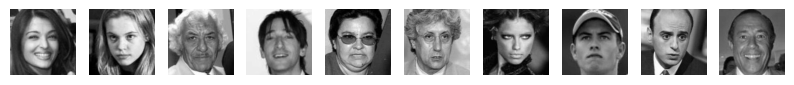

In [6]:
images = X.T
fig, axs = plt.subplots(1, 10, figsize=(10,2))
for i in range(10):
    axs[i].set_axis_off()
    axs[i].imshow(images[i].reshape((sizeimages,sizeimages)), cmap='gray')

### Reducción de dimensionalidad.

Las imágenes tienen una dimensión de 28224, por lo que la ejecución del código directamente sobre ellas requiere muchísimo tiempo. Para intentar solventarlo, podemos reducir la dimensionalidad de los datos de entrada utilizando PCA

In [10]:
from sklearn.decomposition import PCA

X = (images.reshape(-1, sizeimages **2).astype(np.float64) / 255.0).T
pca = PCA(n_components=0.99)  # Mantener el 99% de la varianza.
X_reducido = pca.fit_transform(X.T).T

print('La dimensión de los datos reducidos es ', X_reducido.shape[0])

La dimensión de los datos reducidos es  848


### 70 componentes y 3 factores. Parece funcionar bastante bien.

In [11]:
n_components = 70 # 30
n_latents = 3 # 4
mfa = MixtureFA(n_components=n_components, n_latents=n_latents, max_iter=30, tol=1e-3)
mfa.fit(X_reducido)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1861 is different from 3)

Nuestro MFA ha trabajado en el espacio reducido por lo que ahora tenemos que transformar los factores y covarianzas obtenidos al espacio original. Para ello utilizamos el método `inverse_transform` que, dadas coordenadas en el espacio reducido, devuelve las correspondientes en el espacio original.

In [ ]:
mu = pca.inverse_transform(mfa.get_means())
Psi_small = mfa.get_noise_covariances()
W_small = mfa.get_loadings()
Psi = np.zeros((n_components,sizeimages**2))
W = np.zeros((n_components,sizeimages**2,n_latents))
for i in range(n_components):
    Psi[i] = pca.inverse_transform(Psi_small[i].reshape(1,-1)).reshape(sizeimages**2)
    W[i] = pca.inverse_transform(W_small[i].reshape(1,-1)).reshape(sizeimages**2,n_latents)

W.shape, Psi.shape

### Figura 28.12 (b) de Murphy.

In [ ]:
num_grid = 6
grid = np.linspace(-1,1, num=num_grid)
comp = 9

fig, axs = plt.subplots(num_grid, num_grid, figsize=(num_grid*1.5,num_grid*1.5))
for i, zi in enumerate(grid):
    for j, zj in enumerate(grid):
        axs[i,j].set_axis_off()
        combination = mu[comp] + zi*W[comp,:,1] + zj*W[comp,:,0]
        axs[i,j].imshow(combination.reshape((sizeimages,sizeimages)), cmap='gray')

### Figura 28.12 (a) de Murphy.

In [ ]:
num_grid = 4
comps = np.array([1, 9])

fig, axs = plt.subplots(2, 6, figsize=(10, num_grid*1.5))
plt.axis('off')
for i in range(2):
    for j in range(2):
        axs[i,2*j+ (j% 2)].imshow(mu[comps[j]].reshape((sizeimages,sizeimages)) - W[comps[j],:,i].reshape((sizeimages,sizeimages)), cmap='gray')
        axs[i,2*j+ 1+ (j % 2)].imshow(0.5 + W[comps[j],:,i].reshape((sizeimages,sizeimages)), cmap='gray')
        axs[i,2*j+ 2+(j % 2)].imshow(mu[comps[j]].reshape((sizeimages,sizeimages)) + W[comps[j],:,i].reshape((sizeimages,sizeimages)), cmap='gray')

In [ ]:
fig, axs = plt.subplots(6, 10, figsize=(10, 10))
plt.axis('off')
for i in range(6):
    for j in range(10):
        axs[i,j].imshow(mu[i*10+j].reshape((sizeimages,sizeimages)), cmap='gray')


### Ahora muestreamos (figura 28.11).

Al ser la dimensión elevada, para evitar errores numéricos y mejorar la eficiencia en lugar de utilizar un método predefinido como `multivariate_normal` para muestrear vamos a implementar un método directo que muestrea de una distribución normal estándar (la media es 0 y la covarianza es la identidad) y transforma el resultado en una muestra de la normal que nos interesa.

In [ ]:
def fast_multivariate_normal_diagonal(mean, cov_diag, size=1):
    dim = len(mean)
    std_dev = np.sqrt(cov_diag)
    Z = np.random.standard_normal((dim, size))
    return mean.reshape(-1, 1) + std_dev.reshape(-1, 1) * Z

Definimos una función para muestrear de MFA, similar a la hicimos en su momento para PPCA y FA.

In [ ]:
def sampleMFA(weights, mu, W, Psi, n_samples=1, ks=None):
    rng = np.random.default_rng()
    n_components = weights.shape[0]

    # Muestrear componente.
    if not(isinstance(ks, np.ndarray)):
        ks = rng.choice(n_components, n_samples, p=weights)

    # Muestrear del espacio reducido.
    z = rng.standard_normal((W.shape[2], n_samples)).T

    n_features = W.shape[1]
    X_sampled = np.zeros((n_features, n_samples))
    for i in range(n_samples):
        # Construir normal y generar muestras.
        mean = ...
        X_sampled[:,i] = fast_multivariate_normal_diagonal(..., ...).flatten()

    return X_sampled

In [ ]:
n_samples = 5
weights = mfa.get_weights()
comps = np.ones(n_samples, dtype='int') * 9
sampleX = sampleMFA(weights, mu, W, Psi, n_samples, comps)

In [ ]:
fig, axs = plt.subplots(1, n_samples, figsize=(10, num_grid*1.5))
plt.axis('off')
for i in range(n_samples):
    axs[i].set_axis_off()
    axs[i].imshow(sampleX[:,i].reshape((sizeimages,sizeimages)), cmap='gray')

### Cuestiones
Comenta brevemente los aspectos que te hayan parecido más destacados de este ejercicio.

### Aspectos destacados del ejercicio:

1. **Reducción de dimensionalidad con PCA**:  
   - Las imágenes tienen 28,224 dimensiones. Para hacer el modelo más eficiente, se utiliza PCA para reducir a 70 componentes, lo que mejora el tiempo de cálculo y la estabilidad numérica.

2. **Algoritmo EM (Esperanza-Maximización)**:  
   - En el paso **E**, se calculan las responsabilidades y las esperanzas de los factores latentes.  
   - En el paso **M**, se actualizan los parámetros del modelo, como \(W\) y \(\mu\), usando las expectativas calculadas.

3. **Transformación al espacio original**:  
   - Después de reducir la dimensionalidad, se transforman los factores y covarianzas de vuelta al espacio original usando `inverse_transform`, para generar muestras en el espacio original.

4. **Muestreo directo**:  
   - Se implementa un muestreo directo de una distribución normal estándar, evitando errores numéricos y mejorando la eficiencia en lugar de usar métodos predefinidos como `multivariate_normal`.

5. **Complejidad y precisión**:  
   - La implementación del modelo de mezcla de analizadores de factores es compleja, pero la reducción de dimensionalidad y el muestreo personalizado optimizan su eficiencia.
